C:\Users\mecha\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mecha\Anaconda3\lib\site-packages\ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mecha\Anaconda3\lib\site-packages\ipykernel_launcher.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(                       close  Predictions
 date                                     
 2011-10-13 12:00:00     3.97   -21.308363
 2011-10-14 00:00:00     4.05   -21.350229
 2011-10-14 12:00:00     4.05   -21.368977
 2011-10-15 00:00:00     4.05   -21.373510
 2011-10-15 12:00:00     4.05   -21.370371
 ...                      ...          ...
 2019-10-21 00:00:00  8237.35  8675.874023
 2019-10-21 12:00:00  8213.65  8745.603516
 2019-10-22 00:00:00  8286.60  8811.944336
 2019-10-22 12:00:00  8025.90  8879.845703
 2019-10-23 00:00:00  7995.47  8889.902344
 
 [5864 rows x 2 columns], None, close          474.55024
 Predictions      0.00000
 dtype: float64)

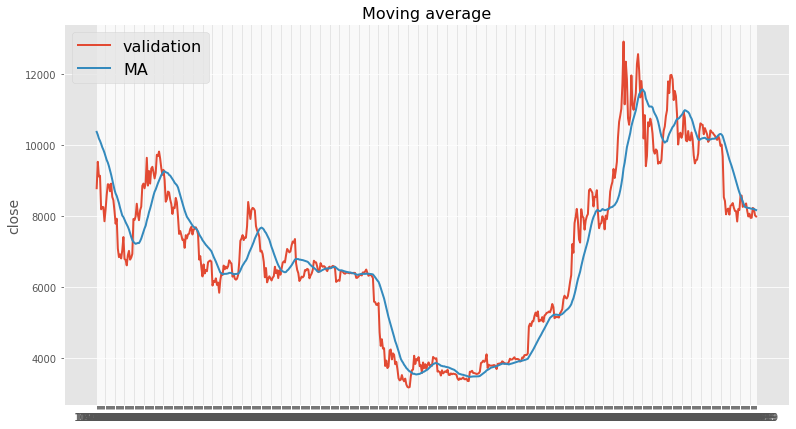

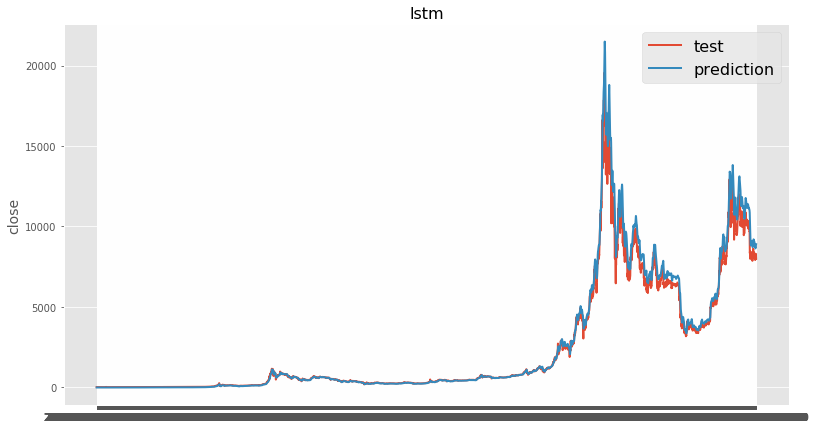

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from sklearn.externals import joblib
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
import math
from keras.models import load_model


# In[19]:


#please change the directory before you run the program
path = r'C:\Users\mecha\Downloads\data\\'
#enter train file_name
train_file_name = 'BTCUSD_1d_2011-09-13_to_2019-10-23_bitstamp.csv'

#enter test file name
test_file_name = 'BTCUSD_12h_2011-09-13_to_2019-10-23_bitstamp.csv'


data_file =path+train_file_name
test_file =path+test_file_name





global win_pred
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('close', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)





def preprocess(file,train_split_ratio, window_l):
    global new_data, train, valid, x_train, y_train, X_val, split, scaler
    win_pred = window_l
    df = pd.read_csv(file)
    for i in range(0,len(df)):
        if (df['volume'][i] == 0):
            df['close'][i]=df['close'][i-1]
    split = math.floor(len(df)*train_split_ratio)
    new_data = df
    decision_var = 'close'
    new_data = new_data.set_index("date")[[decision_var]]
    train = new_data[:split]
    valid = new_data[split:]
    #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(new_data)
    scaler_filename = path+'scaler.save'
    joblib.dump(scaler, scaler_filename)
    scaler = joblib.load(scaler_filename)
    x_train, y_train = [], []
    for i in range(window_l,len(train)):
        x_train.append(scaled_data[i-window_l:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
    #validation
    inputs = new_data[len(new_data) - len(valid) - window_l:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)

    X_val = []
    for i in range(window_l,inputs.shape[0]):
        X_val.append(inputs[i-window_l:i,0])
    X_val = np.array(X_val)

    
    




def moving_average_model(num):
    ma = new_data
    ma['MA'] = ma.rolling(window=num).mean()
    dmf = ma[split:]
    error=[]
    for i in range(0,len(dmf)):
        err= dmf['close'][i]-dmf['MA'][i]
        error.append(err)
    esq=0
    for i in range (0, len(error)):
        esq=error[i]**2+esq
    msq=esq/len(error)
    mse=msq**0.5
    plot = line_plot(dmf['close'], dmf['MA'], 'validation', 'MA',title='Moving average')
    return mse, plot

    
    


# Defining model train and validation


def model_train_validation_run(neurons,epoch,batch):
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=neurons, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=neurons))
    model.add(Dense(1))
    
    
   
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=epoch, batch_size=batch, verbose=2)
    xval = np.reshape(X_val, (X_val.shape[0],X_val.shape[1],1))
    closing_price = model.predict(xval)
    closing_price = scaler.inverse_transform(closing_price)
    valid1 = valid
    valid1['Predictions'] = closing_price
    rms=np.sqrt(np.mean(np.power((valid1-closing_price),2)))
    plot = line_plot(valid1['close'], valid1[['Predictions']], 'validation', 'prediction',title='lstm')
        
    
    
    model.save(path+'model.h5')
    model.save_weights(path+'my_model_weights.h5')
    return rms, plot


#Defining run model


def run_model(file,win_pred=60,scaler_filename='scaler.save',model1 = 'model.h5'):
    global test1
    
    scaler = joblib.load(path+scaler_filename)
    model = load_model(model1)
    df = pd.read_csv(path+file)
    for i in range(0,len(df)):
        if (df['volume'][i] == 0):
            df['close'][i]=df['close'][i-1]
    spl = win_pred
    new_data_t = df
    decision_var = 'close'
    new_data_t = new_data_t.set_index("date")[[decision_var]]
    train_t = new_data_t[:spl]
    valid_t = new_data_t[spl:]
    #converting dataset into x_train and y_train
    
    scaled_data = scaler.fit_transform(new_data_t)
    
    
    
   
    
    #validation
    inputs = new_data_t[len(new_data_t) - len(valid_t) - win_pred:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)

    X_val_t = []
    for i in range(win_pred,inputs.shape[0]):
        X_val_t.append(inputs[i-win_pred:i,0])
    X_val_t = np.array(X_val_t)
    
    xval_t = np.reshape(X_val_t, (X_val_t.shape[0],X_val_t.shape[1],1))
    closing_price = model.predict(xval_t)
    closing_price = scaler.inverse_transform(closing_price)
    test1 = valid_t
    test1['Predictions'] = closing_price
    rms=np.sqrt(np.mean(np.power((test1-closing_price),2)))
    plot = line_plot(test1['close'], test1[['Predictions']], 'test', 'prediction',title='lstm')
    return test1, plot, rms







####uncomment these two below if you want to check training efficiency

preprocess(data_file,0.8,60)





moving_average_model(num=20)


######uncomment if you want to train new model, otherwise use saved model weights

#model_train_validation_run(neurons=60,epoch=15,batch=1)





# To run on unseen test set

run_model(file=test_file_name, win_pred=60,scaler_filename='scaler.save',model1 = 'model.h5')


